In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [ ]:
from tensorflow.keras.losses import binary_crossentropy


In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
# Define VAE architecture
batch_size = 100
original_dim = 28 * 28
latent_dim = 20
intermediate_dim = 256
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)

In [ ]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           5140        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 20)           5140        ['dense[0][0]']                  
                                                                                              

In [ ]:
xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [ ]:
# Train the VAE
vae.fit(x_train, shuffle=True, epochs=100, batch_size=batch_size, validation_data=(x_test, None))



Epoch 1/100
600/600 [==============================] - 6s 8ms/step - loss: 158.6042 - val_loss: 130.4041
Epoch 2/100
600/600 [==============================] - 5s 8ms/step - loss: 124.5515 - val_loss: 118.8518
Epoch 3/100
600/600 [==============================] - 5s 8ms/step - loss: 117.8668 - val_loss: 114.7973
Epoch 4/100
600/600 [==============================] - 5s 8ms/step - loss: 114.6048 - val_loss: 112.3107
Epoch 5/100
600/600 [==============================] - 5s 8ms/step - loss: 112.7794 - val_loss: 111.4373
Epoch 6/100
600/600 [==============================] - 5s 8ms/step - loss: 111.4774 - val_loss: 109.8719
Epoch 7/100
600/600 [==============================] - 5s 8ms/step - loss: 110.5568 - val_loss: 109.9054
Epoch 8/100
600/600 [==============================] - 5s 9ms/step - loss: 109.8979 - val_loss: 108.5440
Epoch 9/100
600/600 [==============================] - 5s 8ms/step - loss: 109.3353 - val_loss: 108.2017
Epoch 10/100
600/600 [==============================] -

600/600 [==============================] - 5s 8ms/step - loss: 103.6354 - val_loss: 104.3218
Epoch 79/100
600/600 [==============================] - 5s 9ms/step - loss: 103.5902 - val_loss: 103.9867
Epoch 80/100
600/600 [==============================] - 5s 9ms/step - loss: 103.6074 - val_loss: 103.3550
Epoch 81/100
600/600 [==============================] - 5s 9ms/step - loss: 103.5681 - val_loss: 103.6605
Epoch 82/100
600/600 [==============================] - 5s 9ms/step - loss: 103.5464 - val_loss: 103.4359
Epoch 83/100
600/600 [==============================] - 5s 9ms/step - loss: 103.5230 - val_loss: 103.7890
Epoch 84/100
600/600 [==============================] - 5s 8ms/step - loss: 103.5043 - val_loss: 103.2627
Epoch 85/100
600/600 [==============================] - 5s 8ms/step - loss: 103.4943 - val_loss: 103.6785
Epoch 86/100
600/600 [==============================] - 5s 8ms/step - loss: 103.4767 - val_loss: 103.6229
Epoch 87/100
600/600 [==============================] - 5s 

100/100 [==============================] - 0s 2ms/step


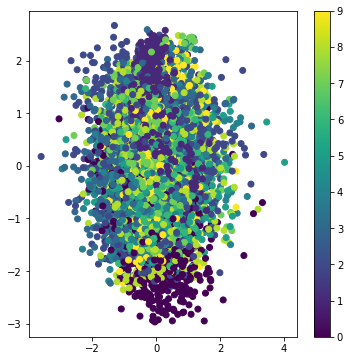

In [ ]:
# Encoder to generate latent variables from input
encoder = Model(x, z_mean)

# Generator to generate image from latent variables
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


# Display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [ ]:
# # Generate a random sample from the standard normal distribution (as an example)
# random_latent_sample = np.random.normal(size=(1, latent_dim))

# # Use the generator model to generate an image from the random sample
# generated_image = generator.predict(random_latent_sample)

# # Plot the generated image
# plt.imshow(generated_image.reshape(28, 28), cmap='gray')
# plt.title('Generated Image')
# plt.show()


In [ ]:
# Generate images using the trained generator
def generate_images(n):
    noise = np.random.normal(0, 1, size=[n, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n, 28, 28)

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest')
#         plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 17ms/step


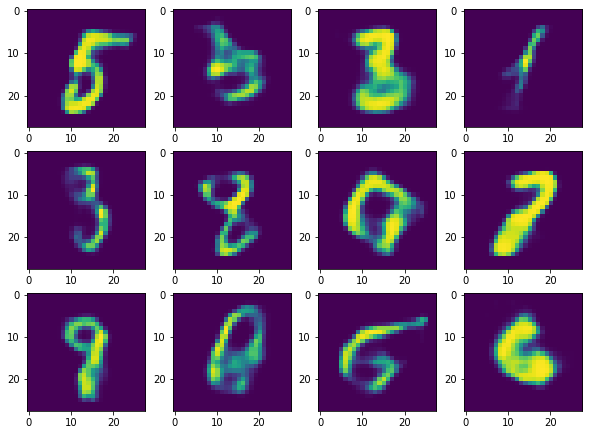

In [ ]:
generate_images(12)